# Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('../RecSys HW 6/retail_train.csv')
item_features = pd.read_csv('../RecSys HW 6/product.csv')
user_features = pd.read_csv('../RecSys HW 6/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\tanbe\RecSys HW 6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

# Eval recall of matching

### Измеряем recall@k

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [15]:
ACTUAL_COL = 'actual'

In [16]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [17]:
def evalRecall(df_result, result_col_name, recommend_model, N):
    target_col_name = 'actual'
    df_result[result_col_name] = df_result['user_id'].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[target_col_name], k=N), axis=1).mean()

In [18]:
%%time
N_PREDICT = [20, 50, 100, 200, 500]

models = {'own_rec': recommender.get_own_recommendations,
          'similar_items': recommender.get_similar_items_recommendation,
          'als_rec': recommender.get_als_recommendations}

results = {'own_rec': [],
           'similar_items': [],
           'als_rec': []}

for n in N_PREDICT:
    for model in models.keys():
        results[model].append(evalRecall(result_eval_matcher, model, models[model], n))

Wall time: 4min 29s


In [19]:
result_eval_matcher.head()

,user_id,actual,own_rec,similar_items,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 948384, 98...","[885290, 1085664, 13007846, 8090541, 1029272, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[5569230, 916122, 1090931, 8090521, 934399, 11..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1096728, 891171, 7025250, 999714, 9881666, 11...","[880888, 6391541, 1099446, 891423, 9677093, 93..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 819308, 941361, 1074754, 110...","[951834, 878996, 933637, 1082185, 965267, 8570..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1068719, 1044078, 7147145, 8293385, 908882, 9...","[989275, 925579, 1006483, 9419888, 839419, 104..."


In [20]:
results

{'own_rec': [0.039284276793729055,
  0.06525657038145165,
  0.09604492955885016,
  0.13537278412833254,
  0.18205324555508703],
 'similar_items': [0.016832098389187256,
  0.032475536763943796,
  0.0521930683485964,
  0.08494403659496678,
  0.13536511235077864],
 'als_rec': [0.029089187267676675,
  0.04861627258504263,
  0.0687858517185903,
  0.09809676959520841,
  0.14678387383105918]}

__Recall at N возрастает с увеличением числа кандидатов, но после N = 200 скорость возрастания снижается -> оптимальное число кандидатов в диапазоне 100-200.Из трех моделей лучший Recall для всех рассмотренных N показывает own recommender.__

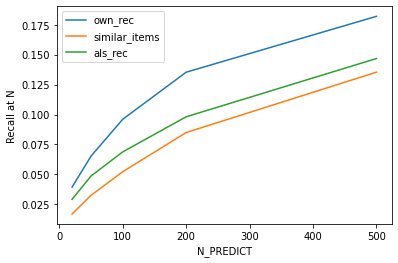

In [21]:
plt.plot(N_PREDICT, results['own_rec'])
plt.plot(N_PREDICT, results['similar_items'])
plt.plot(N_PREDICT, results['als_rec'])

plt.xlabel("N_PREDICT")
plt.ylabel("Recall at N")
plt.legend(labels=["own_rec", "similar_items", "als_rec"])
plt.show()

__N = 150__

In [22]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]

results = {'own_rec': [],
           'similar_items': [],
           'als_rec': []}

result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [23]:
N_PREDICT = 150
for model in models.keys():
    results[model].append(evalRecall(result_eval_matcher, model, models[model], N_PREDICT))

In [24]:
results

{'own_rec': [0.11850827391946671],
 'similar_items': [0.06938635667633457],
 'als_rec': [0.08484777008123331]}

### Recall@5 of matching

In [25]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

        
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [26]:
TOPK_RECALL = 5
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.018201887674891018),
 ('als_rec', 0.014236711033494201),
 ('similar_items', 0.005713038699339055)]

In [27]:
TOPK_PRECISION = 5
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771269176),
 ('als_rec', 0.12068805206880522),
 ('similar_items', 0.06043700604370061)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах

## Подготовка данных для трейна

In [28]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [29]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [30]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [31]:
# Делаем unpivot кандидатов для каждого юзера
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [32]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (322650, 2) Users: 2151 Items: 4594


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [33]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [34]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [35]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [36]:
df_ranker_train.target.value_counts()

0.0    299374
1.0     15235
Name: target, dtype: int64

In [37]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


__На каждого юзера 150 item_id-кандидатов__

In [38]:
df_ranker_train['target'].mean()

0.048425188090614066

## Подготавливаем фичи для обучения модели

In [39]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [40]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


**Фичи user_id:**
    
    - Средний чек
    
    - Частотность покупок раз/месяц

In [41]:
# Средний чек
user_atv = data_train_matcher.groupby(['user_id', 'basket_id'])[['sales_value']].mean().reset_index().groupby('user_id')['sales_value'].mean()
user_atv.name = 'user_atv'
user_atv = np.round(user_atv, decimals=3)
user_atv.head()

user_id
1    3.573
2    4.335
3    4.858
4    5.119
5    5.495
Name: user_atv, dtype: float64

In [42]:
# Частотность покупок раз/месяц
data_train_matcher['month'] = data_train_matcher['day'].apply(lambda x: (x+30)//30)

avg_month_count = data_train_matcher.groupby(['user_id']).agg({ 'month': ['min', 'max'] }).reset_index()
avg_month_count['months_count'] = avg_month_count['month','max'] - avg_month_count['month','min']
avg_month_count.drop([('month','min'), ('month','max')], axis=1, inplace=True)
avg_month_count.set_index('user_id',inplace = True)

user_freq = data_train_matcher.groupby(['user_id'])['basket_id'].count() / avg_month_count['months_count']
user_freq.name = 'monthly_user_frequency'
user_freq = np.round(user_freq, decimals=3)
user_freq.head()

user_id
1    36.722
2    19.562
3    15.938
4    10.688
5     7.941
Name: monthly_user_frequency, dtype: float64

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории

In [43]:
# Среднее кол-во покупок item_id в неделю
item_per_week = data_train_matcher.groupby(['item_id'])['quantity'].sum().rename('item_per_week') / data_train_matcher['week_no'].max() 
item_per_week = np.round(item_per_week, decimals=3)
item_per_week.head()

item_id
117847    0.576
818981    0.906
819255    2.776
819308    3.682
819400    0.929
Name: item_per_week, dtype: float64

In [44]:
# Среднее кол-во покупок 1 товара в категории в неделю
data_categ = pd.merge(data_train_matcher, item_features, how='inner', on='item_id')

categ_freq_ = data_categ.groupby(['department'])['quantity'].sum()
categ_item_freq_ = data_categ.groupby(['department','item_id'])['quantity'].sum().reset_index()

categ_freq = pd.merge(categ_item_freq_, categ_freq_, on='department')
categ_freq['category_freq'] = categ_freq['quantity_y'] / data_train_matcher['week_no'].max() / categ_freq['quantity_x']
categ_freq.set_index('item_id', inplace=True)
category_freq = categ_freq['category_freq']
category_freq = np.round(category_freq, decimals=3)
category_freq.head()

item_id
1101805    0.012
819978     0.666
823862     2.058
825621     8.932
827656     1.116
Name: category_freq, dtype: float64

In [45]:
# (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
freq_ratio_1 = item_per_week / category_freq
freq_ratio_1.name = 'freq_ratio_1'
freq_ratio_1 = np.round(freq_ratio_1, decimals=3)
freq_ratio_1.head()

item_id
117847    0.413
818981    0.015
819255    0.861
819308    1.288
819400    0.016
Name: freq_ratio_1, dtype: float64

**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [46]:
# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

categ_user_freq_ = data_categ.groupby(['user_id', 'department'])['quantity'].sum().reset_index()
categ_user_freq_['category_freq'] = categ_user_freq_['quantity'] / data_train_matcher['week_no'].max()

categ_user_freq = pd.merge(categ_user_freq_, categ_freq_, on='department')
categ_user_freq['avg_weekly_freq'] = categ_user_freq['quantity_y'] / data_train_matcher['week_no'].max()
categ_user_freq['freq_ratio_2'] = categ_user_freq['category_freq'] / categ_user_freq['avg_weekly_freq']

user_dep_ratio_2 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_2'], axis=1)
user_dep_ratio_2 = np.round(user_dep_ratio_2, decimals=5)
user_dep_ratio_2.head()

,user_id,department,freq_ratio_2
0,1,DELI,0.00117
1,2,DELI,0.00033
2,3,DELI,0.00012
3,4,DELI,0.00003
4,5,DELI,0.00015


In [47]:
# (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

categ_user_freq['freq_ratio_3'] = categ_user_freq['category_freq'] - categ_user_freq['avg_weekly_freq']
user_dep_ratio_3 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_3'], axis=1)
user_dep_ratio_3 = np.round(user_dep_ratio_3, decimals=2)
user_dep_ratio_3.head()

,user_id,department,freq_ratio_3
0,1,DELI,-392.53
1,2,DELI,-392.86
2,3,DELI,-392.94
3,4,DELI,-392.98
4,5,DELI,-392.93


In [48]:
user_features = user_features.merge(user_atv, how='left', on='user_id', suffixes=(False, False))
user_features = user_features.merge(user_freq, how='left', on='user_id', suffixes=(False, False))

user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,user_atv,monthly_user_frequency
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3.573,36.722
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,4.708,20.263
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,5.066,35.412
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,6.894,54.062
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,3.596,14.812


In [49]:
item_features = item_features.merge(item_per_week, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(category_freq, how='left', on='item_id', suffixes=(False, False))
item_features = item_features.merge(freq_ratio_1, how='left', on='item_id', suffixes=(False, False))

item_features[item_features['category_freq'].isna()].head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,category_freq,freq_ratio_1
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,NaN,NaN,NaN
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,NaN,NaN,NaN
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,NaN,NaN,NaN
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,NaN,NaN,NaN
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,NaN,NaN,NaN


In [50]:
df_ranker_train = df_ranker_train.merge(item_features, how='left', on='item_id', suffixes=(None, None))
df_ranker_train = df_ranker_train.merge(user_features, how='left', on='user_id', suffixes=(None, None))

In [51]:
df_ranker_train = pd.merge(df_ranker_train, user_dep_ratio_2, on=['user_id', 'department'], how='left')

In [52]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [53]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'item_per_week',
 'category_freq',
 'freq_ratio_1',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_atv',
 'monthly_user_frequency',
 'freq_ratio_2']

## Обучение модели ранжирования

In [54]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=12,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

c:\users\tanbe\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\tanbe\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\tanbe\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [55]:
df_ranker_predict = df_ranker_train.copy()

In [56]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [57]:
# Преобразуем тестовый датасет в нужный формат
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [58]:
%%time
# выбранный ранее N_PREDICT = 150, лучшая модель own_recommend
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 9.94 s


In [59]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.14441176470588235)]

In [60]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [61]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [62]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.19321148825065274)
('own_rec', 0.14441176470588235)


C:\Users\tanbe\RecSys HW 6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Precision вырос в двухуровневой модели.